# Filter shift estimates for GNIRS acquistion

Details on the procedure are in [this internal page](http://internal.gemini.edu/science/instruments/GNIRS/Systems_Reference/filters/shifts.html).

## Load modules and read the data

In [63]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import gnirs
from gnirs.io import fits
from gnirs import quick_photometry

from astropy.io import ascii
from astropy.io import fits as astropyfits
from astropy.table import column


from matplotlib import pyplot as plt
from matplotlib.patches import Circle, Annulus

from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.visualization import (MinMaxInterval, SqrtStretch,
                                   ImageNormalize)


import astropy.units as u
import numpy as np

In [46]:
root_directory='/Users/emanuele.farina/Desktop/GEMINI/FilterShift/'
# Where the fits files are
data_directory=root_directory+'Data/'
# Where the information on the data collected are
# Note that beacuse the data are collected via the DM, the header of the files
# are highly incompleted. So the information on the filter used needs to be 
# retrived from the this data table
data_table_file=root_directory+'GNIRS_filter_shift_data_Mar2022.csv'
# This is used to read the file number and convert it into a fits file name
# Technically, this part is not necessary, but it is useful if a lot of fits
# files are stored in the same directory
root_filename='N20220407S'
# Initial guess on the source location
initial_location = (312.0, 568.0)
# size of the area where to find the centroid
radius = 25.0
# ragion where to estimate the background
radius_in_bkg = 30.0
radius_out_bkg = 35.0
# centroid function
centroid_function = 'com'

In [47]:
data_table = ascii.read(data_table_file)
data_table.show_in_notebook(display_length=3)

idx,Filter,File,X (pix),Y (pix),Lowest X,Highest X,Lowest Y,Highest Y,Area
0,Y-MK + XD,86,--,--,--,--,--,--,--
1,Y-MK + XD,87,--,--,--,--,--,--,--
2,Y-MK + XD,88,--,--,--,--,--,--,--
3,Y-MK + XD,89,--,--,--,--,--,--,--
4,Y-MK + XD,90,--,--,--,--,--,--,--
5,Y-MK + XD,91,--,--,--,--,--,--,--
6,Y-MK + XD,92,--,--,--,--,--,--,--
7,Y-MK + XD,93,--,--,--,--,--,--,--
8,Y-MK + XD,94,--,--,--,--,--,--,--
9,Y-MK + XD,95,--,--,--,--,--,--,--


## Some cleaning

In [48]:
# update the fits file names
fits_file_array = np.empty_like(data_table['File'].data, dtype='object')
for idx in range(len(data_table['File'].data)):
    fits_file_array[idx] = root_filename + str(data_table['File'].data[idx]).zfill(4) + '.fits'
fits_file_column = column.Column(name='fits_file', data=fits_file_array, dtype=str)
data_table.add_column(fits_file_column)
data_table.show_in_notebook(display_length=3)

idx,Filter,File,X (pix),Y (pix),Lowest X,Highest X,Lowest Y,Highest Y,Area,fits_file
0,Y-MK + XD,86,--,--,--,--,--,--,--,N20220407S0086.fits
1,Y-MK + XD,87,--,--,--,--,--,--,--,N20220407S0087.fits
2,Y-MK + XD,88,--,--,--,--,--,--,--,N20220407S0088.fits
3,Y-MK + XD,89,--,--,--,--,--,--,--,N20220407S0089.fits
4,Y-MK + XD,90,--,--,--,--,--,--,--,N20220407S0090.fits
5,Y-MK + XD,91,--,--,--,--,--,--,--,N20220407S0091.fits
6,Y-MK + XD,92,--,--,--,--,--,--,--,N20220407S0092.fits
7,Y-MK + XD,93,--,--,--,--,--,--,--,N20220407S0093.fits
8,Y-MK + XD,94,--,--,--,--,--,--,--,N20220407S0094.fits
9,Y-MK + XD,95,--,--,--,--,--,--,--,N20220407S0095.fits


In [49]:
data_table['X (pix)'].dtype = float
data_table['Y (pix)'].dtype = float

## Calculate Centroids

In [50]:
for idx in range(len(data_table['File'].data)):
    try:
        gnirs_fits = fits.GnirsFits(data_directory+data_table['fits_file'][idx])
        # These need to added because data are coming form the DM
        # so the information is not present in the header
        gnirs_fits.data_type = 'IMAGING'
        gnirs_fits.pixel_scale = 0.05 * u.arcsec / u.pixel
        gnirs_fits.filter_one = data_table['Filter'][idx].split('+')[0].strip()
        gnirs_fits.filter_two = data_table['Filter'][idx].split('+')[1].strip()
        centroid = quick_photometry.get_centroid(gnirs_fits, initial_location, radius, 
                                                 radius_in_bkg, radius_out_bkg, 
                                                 centroid_function=centroid_function)
        data_table['X (pix)'].data[idx] = centroid[0]
        data_table['Y (pix)'].data[idx] = centroid[1]
    except ValueError:
        print('Missing file: {}'.format(data_directory+data_table['fits_file'][idx]))

In [51]:
data_table.show_in_notebook(display_length=3)

idx,Filter,File,X (pix),Y (pix),Lowest X,Highest X,Lowest Y,Highest Y,Area,fits_file
0,Y-MK + XD,86,312.2195865993625,563.4745879966465,--,--,--,--,--,N20220407S0086.fits
1,Y-MK + XD,87,312.19485243353495,563.326543816253,--,--,--,--,--,N20220407S0087.fits
2,Y-MK + XD,88,312.2279701499539,563.524691961284,--,--,--,--,--,N20220407S0088.fits
3,Y-MK + XD,89,312.2511676654857,563.3614143433267,--,--,--,--,--,N20220407S0089.fits
4,Y-MK + XD,90,312.099618163135,563.3889053231406,--,--,--,--,--,N20220407S0090.fits
5,Y-MK + XD,91,312.21145652516964,563.5104031876282,--,--,--,--,--,N20220407S0091.fits
6,Y-MK + XD,92,312.2649910928665,563.3588664704515,--,--,--,--,--,N20220407S0092.fits
7,Y-MK + XD,93,312.0760072104196,563.2453120439252,--,--,--,--,--,N20220407S0093.fits
8,Y-MK + XD,94,312.1466691506677,563.352464063695,--,--,--,--,--,N20220407S0094.fits
9,Y-MK + XD,95,312.1468405313986,563.4647247414089,--,--,--,--,--,N20220407S0095.fits


## Plot Centroids

In [52]:
filter_list = ['Y-MK + XD', 'J-MK + XD', 'K-MK + XD', 'Open + XD']

In [66]:
def plot_centroids(fits_file, filter_name, x_cen, y_cen, radius, radius_in_bkg, radius_out_bkg):
    image_data = astropyfits.open(fits_file)[1].data
    norm = ImageNormalize(image_data[int(x_cen-radius_out_bkg):int(x_cen+radius_out_bkg), 
                                     int(y_cen-radius_out_bkg):int(y_cen+radius_out_bkg)], 
                          interval=MinMaxInterval(),
                          stretch=SqrtStretch())
    print(fits_file, filter_name)
    plt.figure()
    plt.imshow(image_data, cmap='gray', origin='lower', norm=norm)
    plt.xlim(int(x_cen-radius_out_bkg),int(x_cen+radius_out_bkg))
    plt.ylim(int(y_cen-radius_out_bkg),int(y_cen+radius_out_bkg))
    plt.plot([x_cen], [y_cen], marker="x", markersize=20, markeredgecolor="red", markerfacecolor="None")
    circle = Circle((x_cen,y_cen), radius, alpha=1, ec='red', fc='None')
    background = Annulus((x_cen,y_cen), radius_in_bkg, radius_out_bkg-radius_in_bkg, alpha=1, ec='blue', fc='None')

    plt.gca().add_patch(circle)
    plt.gca().add_patch(background)
    plt.colorbar()
    plt.show()
    
    

/Users/emanuele.farina/Desktop/GEMINI/FilterShift/Data/N20220407S0086.fits Y-MK + XD


/var/folders/lb/dp07tycn66lg6vn9s48c_j6m000g04/T/ipykernel_50950/3421705201.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


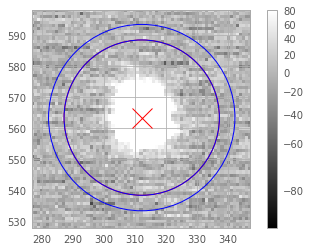

/Users/emanuele.farina/Desktop/GEMINI/FilterShift/Data/N20220407S0087.fits Y-MK + XD


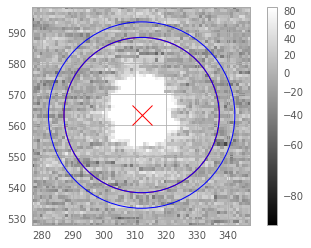

/Users/emanuele.farina/Desktop/GEMINI/FilterShift/Data/N20220407S0088.fits Y-MK + XD


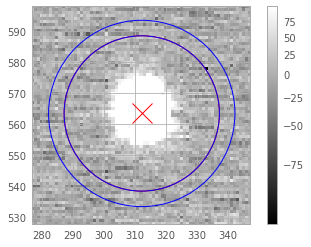

/Users/emanuele.farina/Desktop/GEMINI/FilterShift/Data/N20220407S0089.fits Y-MK + XD


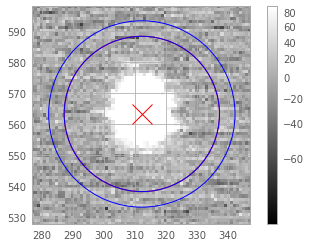

/Users/emanuele.farina/Desktop/GEMINI/FilterShift/Data/N20220407S0090.fits Y-MK + XD


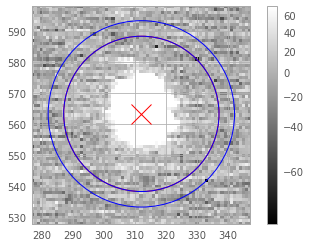

/Users/emanuele.farina/Desktop/GEMINI/FilterShift/Data/N20220407S0091.fits Y-MK + XD


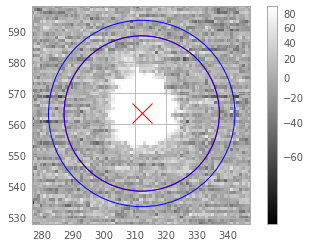

/Users/emanuele.farina/Desktop/GEMINI/FilterShift/Data/N20220407S0092.fits Y-MK + XD


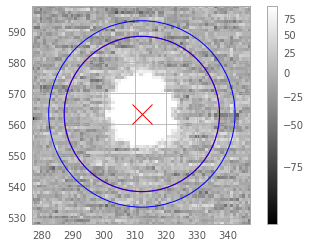

/Users/emanuele.farina/Desktop/GEMINI/FilterShift/Data/N20220407S0093.fits Y-MK + XD


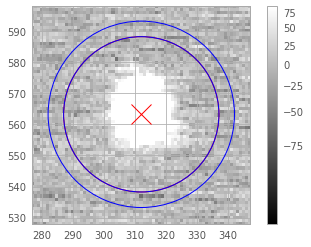

/Users/emanuele.farina/Desktop/GEMINI/FilterShift/Data/N20220407S0094.fits Y-MK + XD


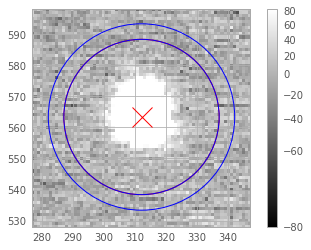

/Users/emanuele.farina/Desktop/GEMINI/FilterShift/Data/N20220407S0095.fits Y-MK + XD


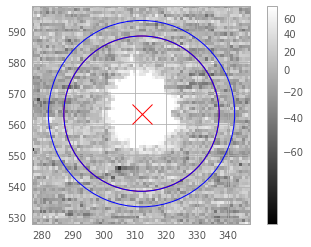

/Users/emanuele.farina/Desktop/GEMINI/FilterShift/Data/N20220407S0096.fits J-MK + XD


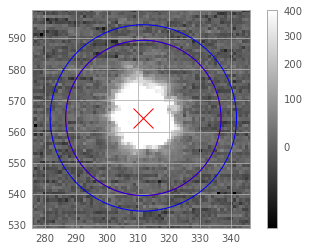

/Users/emanuele.farina/Desktop/GEMINI/FilterShift/Data/N20220407S0097.fits J-MK + XD


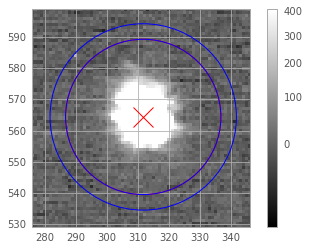

/Users/emanuele.farina/Desktop/GEMINI/FilterShift/Data/N20220407S0098.fits J-MK + XD


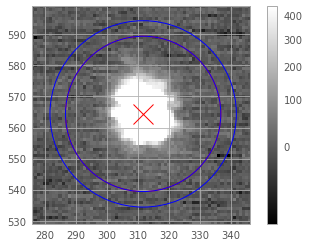

/Users/emanuele.farina/Desktop/GEMINI/FilterShift/Data/N20220407S0099.fits J-MK + XD


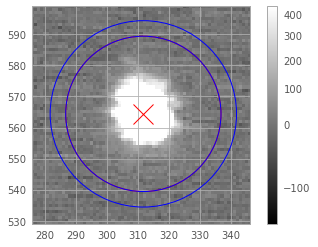

/Users/emanuele.farina/Desktop/GEMINI/FilterShift/Data/N20220407S0100.fits J-MK + XD


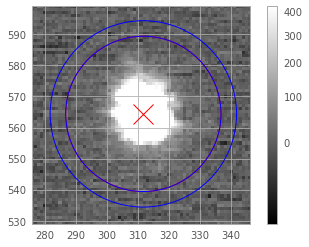

/Users/emanuele.farina/Desktop/GEMINI/FilterShift/Data/N20220407S0101.fits J-MK + XD


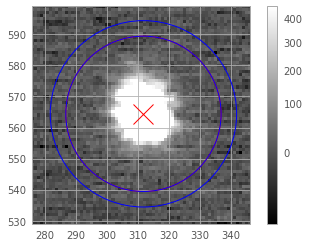

/Users/emanuele.farina/Desktop/GEMINI/FilterShift/Data/N20220407S0102.fits J-MK + XD


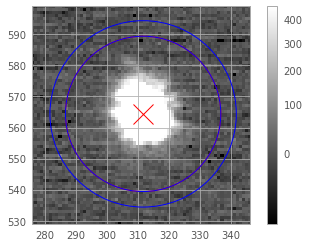

/Users/emanuele.farina/Desktop/GEMINI/FilterShift/Data/N20220407S0103.fits J-MK + XD


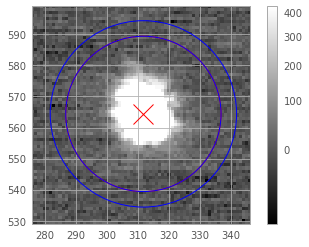

/Users/emanuele.farina/Desktop/GEMINI/FilterShift/Data/N20220407S0104.fits J-MK + XD


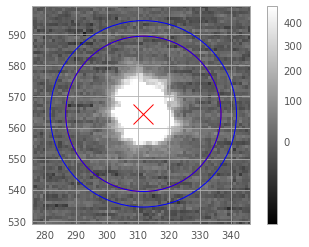

/Users/emanuele.farina/Desktop/GEMINI/FilterShift/Data/N20220407S0105.fits J-MK + XD


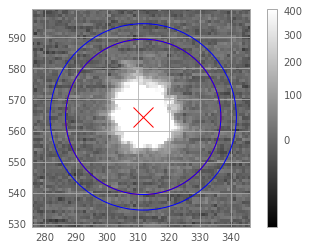

/Users/emanuele.farina/Desktop/GEMINI/FilterShift/Data/N20220407S0106.fits K-MK + XD


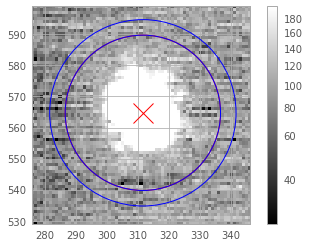

/Users/emanuele.farina/Desktop/GEMINI/FilterShift/Data/N20220407S0107.fits K-MK + XD


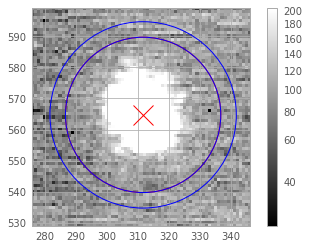

/Users/emanuele.farina/Desktop/GEMINI/FilterShift/Data/N20220407S0108.fits K-MK + XD


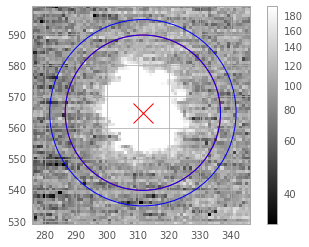

/Users/emanuele.farina/Desktop/GEMINI/FilterShift/Data/N20220407S0109.fits K-MK + XD


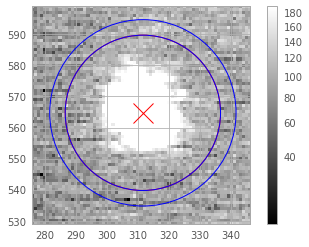

/Users/emanuele.farina/Desktop/GEMINI/FilterShift/Data/N20220407S0110.fits K-MK + XD


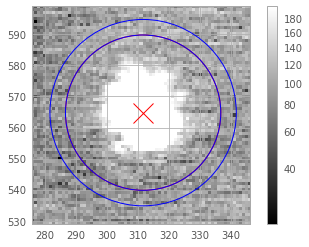

/Users/emanuele.farina/Desktop/GEMINI/FilterShift/Data/N20220407S0111.fits K-MK + XD


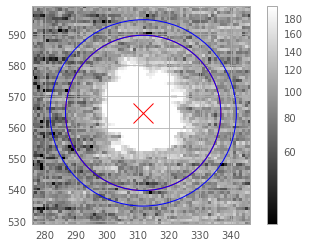

/Users/emanuele.farina/Desktop/GEMINI/FilterShift/Data/N20220407S0112.fits K-MK + XD


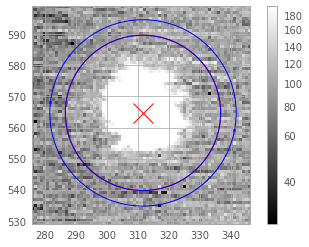

/Users/emanuele.farina/Desktop/GEMINI/FilterShift/Data/N20220407S0113.fits K-MK + XD


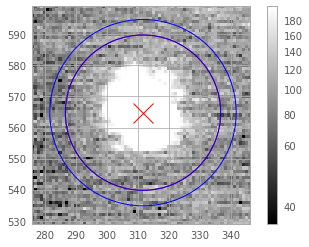

/Users/emanuele.farina/Desktop/GEMINI/FilterShift/Data/N20220407S0114.fits K-MK + XD


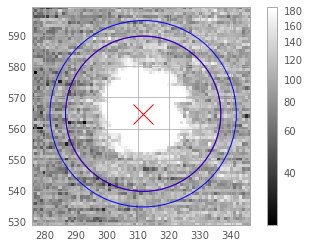

In [ ]:
for idx in range(len(data_table['File'].data)):
    plot_centroids(data_directory+data_table['fits_file'][idx], data_table['Filter'][idx], 
                   data_table['X (pix)'][idx], data_table['Y (pix)'][idx],
                   radius, radius_in_bkg, radius_out_bkg)

In [55]:
filter_YMKXD = (data_table['Filter'].data == 'Y-MK + XD')
filter_JMKXD = (data_table['Filter'].data == 'J-MK + XD')
filter_KMKXD = (data_table['Filter'].data == 'K-MK + XD')
filter_OpenXD = (data_table['Filter'].data == 'Open + XD')

x_YMKXD = data_table['X (pix)'].data[filter_YMKXD]
y_YMKXD = data_table['Y (pix)'].data[filter_YMKXD]
x_JMKXD = data_table['X (pix)'].data[filter_JMKXD]
y_JMKXD = data_table['Y (pix)'].data[filter_JMKXD]
x_KMKXD = data_table['X (pix)'].data[filter_KMKXD]
y_KMKXD = data_table['Y (pix)'].data[filter_KMKXD]
x_OpenMKXD = data_table['X (pix)'].data[filter_OpenXD]
y_OpenMKXD = data_table['Y (pix)'].data[filter_OpenXD]

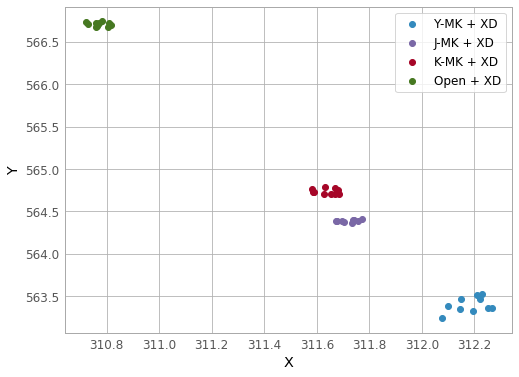

In [56]:
plt.scatter(x_YMKXD, y_YMKXD, label='Y-MK + XD')
plt.scatter(x_JMKXD, y_JMKXD, label='J-MK + XD')
plt.scatter(x_KMKXD, y_KMKXD, label='K-MK + XD')
plt.scatter(x_OpenMKXD, y_OpenMKXD, label='Open + XD')
plt.xlabel(r'X')
plt.ylabel(r'Y')
plt.legend()

In [57]:
median_y_openMKXD = np.nanmedian(y_OpenMKXD)
median_x_openMKXD = np.nanmedian(x_OpenMKXD)

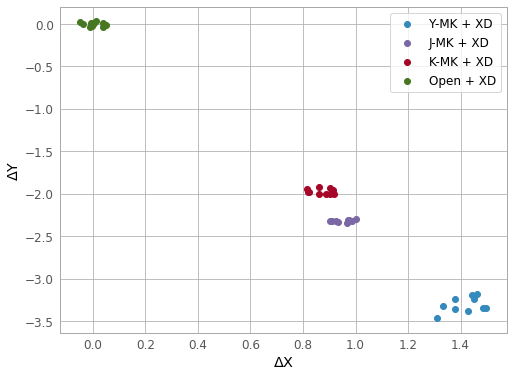

In [58]:
plt.scatter(x_YMKXD-median_x_openMKXD, y_YMKXD-median_y_openMKXD, label='Y-MK + XD')
plt.scatter(x_JMKXD-median_x_openMKXD, y_JMKXD-median_y_openMKXD, label='J-MK + XD')
plt.scatter(x_KMKXD-median_x_openMKXD, y_KMKXD-median_y_openMKXD, label='K-MK + XD')
plt.scatter(x_OpenMKXD-median_x_openMKXD, y_OpenMKXD-median_y_openMKXD, label='Open + XD')
plt.xlabel(r'$\Delta$X')
plt.ylabel(r'$\Delta$Y')
plt.legend()

In [59]:
print('Average Shift:')
print('XD vs Y-MK: {:1.3f}+/-{:1.3f}'.format(np.nanmean( y_YMKXD-median_y_openMKXD), 
                                             np.nanstd( y_YMKXD-median_y_openMKXD)))
print('XD vs J-MK: {:1.3f}+/-{:1.3f}'.format(np.nanmean( y_JMKXD-median_y_openMKXD), 
                                             np.nanstd( y_JMKXD-median_y_openMKXD)))
print('XD vs K-MK: {:1.3f}+/-{:1.3f}'.format(np.nanmean( y_KMKXD-median_y_openMKXD), 
                                             np.nanstd( y_KMKXD-median_y_openMKXD)))

Average Shift:
XD vs Y-MK: -3.308+/-0.085
XD vs J-MK: -2.321+/-0.012
XD vs K-MK: -1.971+/-0.030
